In [23]:
import sys
sys.path.insert(0, './FirstMultiModel/EEGART')

from transformers import Trainer, TrainingArguments

import torch
import torch.nn as nn
import numpy as np

import sys
sys.path.insert(0, './Dataloader')
import torch
from torch.utils.data import Dataset, DataLoader
from SLT_dataloader import RandonMaskDataCollator,ART_AUG_RandonMaskDataCollator

from tf_config import SLTConfig
from tf_model import SLTModel, pre_SLTModel
from datetime import datetime

# 指定 checkpoint 的路徑
checkpoint_path = "G:\\共用雲端硬碟\\CNElab_專題111_ArtifactRemoval\\6.Opendataset\\0.Resting(train)\\2.rawdata\\test\\MASK20_ART_outputmask_prob_08_tgtwithoutEEG_learnable_position__20250614_000148\\checkpoint-11100" #"./results_3pca/mask_prob_05_tgtwithoutEEG__20250429_163905/checkpoint-35405"

# 載入 config
config = SLTConfig.from_pretrained(checkpoint_path)

# 載入 model
model = pre_SLTModel.from_pretrained(checkpoint_path, config=config)

# 移到 GPU（如果有的話）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [24]:
import sys
sys.path.insert(0, './Dataloader')
from SLT_dataloader import EEGROI_Power_Dataset, EEGROI_fft_Dataset,CSVEEGDataset

eval_eeg_folder="G:\\共用雲端硬碟\\CNElab_專題111_ArtifactRemoval\\6.Opendataset\\0.Resting(train)\\2.rawdata\\test\\eval_eeg"

eval_dataset = CSVEEGDataset(eeg_folder=eval_eeg_folder, group_name="eval_dataset",window_size=512, stride=256)

print(len(eval_dataset))

Processed EEG segments: 3, skipped (NaN/Inf): 0
3


In [25]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset


data_collator = ART_AUG_RandonMaskDataCollator(mask_prob=0.3) #mask_channel=[14]


train_loader =  DataLoader(eval_dataset, batch_size=1, collate_fn=data_collator)
# eval_loader = DataLoader(eval_dataset, batch_size=256, collate_fn=data_collator)

for batch in train_loader:
    mask = batch['tgt_token_mask']

    model.eval()
    with torch.no_grad():
        outputs = model(
            src=batch['src'].to(device),
            tgt=batch['tgt'].to(device),
            tgt_token_mask=batch['tgt_token_mask'].to(device),
            return_dict=True,
            labels=batch['labels'].to(device)
        )
    
    loss = outputs['loss']
    preds = outputs['logits']
    attention_map = outputs['attentions']
    
    break

# 清除 model 和 GPU 記憶體
# del model
# torch.cuda.empty_cache()


In [26]:
loss

tensor(0.0393)

In [27]:
preds = outputs['logits']         # shape: (1, 30, 101)
labels = batch['labels']          # shape: (1, 30, 101)

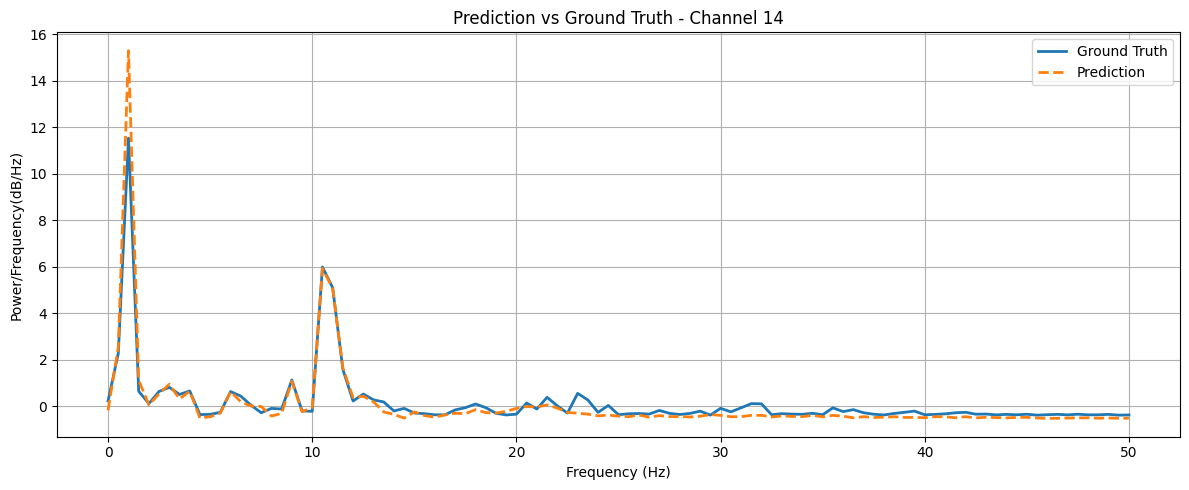

In [28]:
import matplotlib.pyplot as plt

channel_idx = 14

# 取出第 0 個 batch、第 14 個 channel 的頻譜
preds = outputs['logits']         # shape: (1, 30, 101)
labels = batch['labels']          # shape: (1, 30, 101)
pred = preds[0, channel_idx].cpu().numpy()     # (101,)
true = labels[0, channel_idx].cpu().numpy()    # (101,)
freqs = np.linspace(0, 50, 101)# 頻率軸對應 (0~50 Hz)

# 轉換成 dB/Hz


pred = torch.tensor(pred)  # 如果還是 numpy
true = torch.tensor(true)
eps = 1e-10
pred_db = 10 * torch.log10(pred + eps)
true_db = 10 * torch.log10(true + eps)


plt.figure(figsize=(12, 5))
plt.plot(freqs, true, label='Ground Truth', linewidth=2)
plt.plot(freqs, pred, label='Prediction', linestyle='--', linewidth=2)
plt.title(f'Prediction vs Ground Truth - Channel {channel_idx}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency(dB/Hz)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# 模擬假資料（實際情況請改成你的 model 輸出）
batch_size = 8
num_channels = 30
freq_bins = 101


# ➤ 1. 計算 Overall MSE（整體）
overall_mse = F.mse_loss(preds, labels)
print(f"Overall MSE: {overall_mse.item():.6f}")

# ➤ 2. 計算 Channel-wise MSE（每個通道）
channel_mse = torch.mean((preds - labels) ** 2, dim=(0, 2))  # (channel,)
print("Channel-wise MSE:", channel_mse)
print(channel_mse[14])
# ➤ 3. 計算 Masked Channel 的 MSE（可選）
mask = tgt_token_mask.unsqueeze(-1).expand(-1, -1, freq_bins)  # shape: (batch, channel, freq)
if mask.sum() > 0:
    masked_mse = F.mse_loss(preds[mask], labels[mask])
   # print(f"Masked Channels MSE: {masked_mse.item():.6f}")
else:
    print("No masked channels in this batch.")

# ➤ 4. 視覺化 Channel-wise MSE（可選）
channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
                 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4',
                 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz',
                 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']
print(channel_names[14])


Overall MSE: 0.090264
Channel-wise MSE: tensor([0.0668, 0.0419, 0.0529, 0.0613, 0.2468, 0.1006, 0.0530, 0.0614, 0.0918,
        0.0693, 0.1168, 0.0620, 0.0434, 0.0816, 0.1890, 0.0847, 0.0227, 0.0338,
        0.1451, 0.1238, 0.1461, 0.0255, 0.0635, 0.0771, 0.1129, 0.0751, 0.0523,
        0.2258, 0.1028, 0.0782])
tensor(0.1890)


NameError: name 'tgt_token_mask' is not defined

In [36]:
import torch
import numpy as np

# preds, labels: shape (batch, channel, freq)
channel_mse = torch.mean((preds - labels) ** 2, dim=(0, 2))  # → shape: (channel,)
channel_mse = channel_mse.cpu().numpy()

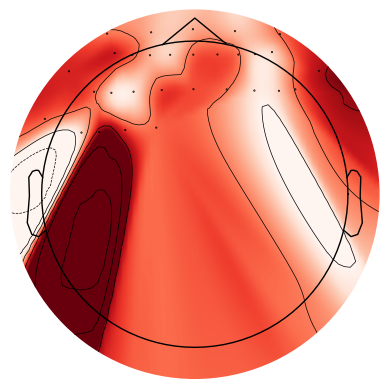

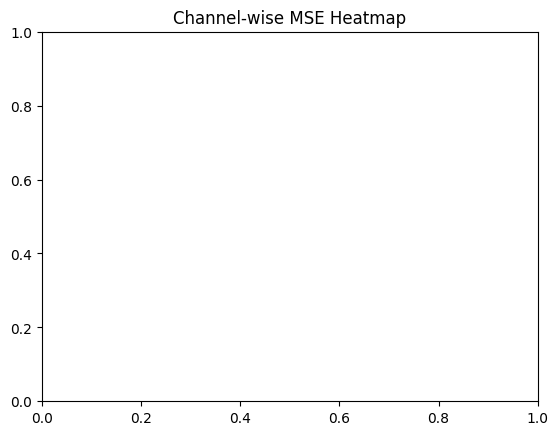

In [37]:
import mne
import matplotlib.pyplot as plt

# 假設你是 30 channel 的標準 layout，可以試用 'standard_1020'
montage = mne.channels.make_standard_montage('standard_1020')

# 製作 info（假設 sampling rate 隨便設一個，因為只畫 topomap 用不到）
info = mne.create_info(ch_names=montage.ch_names[:30], sfreq=100, ch_types='eeg')
info.set_montage(montage)

# 創建 topomap plot（你要確保 channel_mse 對應這些 channel 的順序）
fig, ax = plt.subplots()
mne.viz.plot_topomap(channel_mse, info, axes=ax, show=True, cmap="Reds")
plt.title("Channel-wise MSE Heatmap")
plt.show()


In [56]:
channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 
                'T7', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 
                'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']
info = mne.create_info(ch_names=channel_names, sfreq=100, ch_types='eeg')
info.set_montage(montage)


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, ...
 chs: 30 EEG
 custom_ref_applied: False
 dig: 33 items (3 Cardinal, 30 EEG)
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: unspecified
 nchan: 30
 projs: []
 sfreq: 100.0 Hz
>